# Tract assortativity

In this notebook, we test the following hypothesis:

**Tracts can be ranked according to the similarity of brain regions that connect to it. This reflects the unimodal-to-transmodalness of tracts.**

Approach:

* Generate an affinity matrix that reflect the similarity of pairs of brain regions across selected cortical features. 
* Generate regions x regions "tract masks", where 1 indicates both regions are connecting to a given tract; 0 indicates that one or both regions are not connected.
* t-tests comparing the similarity of cortical features in connected vs unconnected regions.
* Comparison against shuffled tract-to-region probabilities. 
* A significant result would indicate that brain regions linked to this tract are more similar to each other compared to regions not connected to the tract.

In [1]:
# let's import the needed packages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
from neuromaps.datasets import fetch_fslr, fetch_annotation
from neuromaps import datasets, images, nulls, resampling, stats, transforms, parcellate
from surfplot import Plot
from neuromaps.parcellate import Parcellater, _gifti_to_array
from neuromaps.resampling import resample_images
from neuromaps.images import dlabel_to_gifti
import neuromaps
import nibabel as nib
import os
import numpy as np
import mayavi
from PIL import Image
import hcp_utils as hcp
import nilearn.plotting as plotting
import tractmaps_utils
import snf
from sklearn import cluster
from snf import metrics
from scipy import stats as sstats

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


## Load data
Run the cortical features cell OR the neurosynth cell depending on which maps you want to run analyses on. 

In [2]:
### CORTICAL FEATURES DATA ###
analysis = 'cortex'
data = pd.read_csv('./inputs/tracts_maps_Glasser.csv')

In [2]:
### NEUROSYNTH DATA ###
analysis = 'neurosynth'
data = pd.read_csv('./inputs/tracts_neurosynth_Glasser.csv')

In [3]:
# set up inputs
maps_df = data.iloc[:, 59:]
maps_list = [maps_df[col].values for col in maps_df.columns]
map_names = list(maps_df)
glasser_maps = maps_df.to_dict(orient = 'list')
glasser_maps = {key: np.array(value) for key, value in glasser_maps.items()} # store parcellated maps as dictionary of map_names and arrays

## Test tract similarity

In [6]:
# define parameters
map_names = list(glasser_maps.keys())
tract_names = list(data.filter(regex = 'left|right').columns)
tract_names = [item for item in tract_names if item not in ['F_left', 'F_right']] # remove fornix (not used below)
n_tracts = len(tract_names)
df = data
connection_threshold = 0.95
nspins = 10000
testtype = 'twotailed'
glasser = tractmaps_utils.get_glasser() # load glasser parcellation GIFTI images (lh, rh)

In [7]:
def generate_mean_diff(tract_probs, tract_name, similarities_dict, connection_threshold = 0.95):
    """
    Generate difference in means of brain regions connected vs non-connected to a tract. 
    It involves generating tract connection masks based on an array of probabilities of connection across all brain regions (brain regions, 1).
    Next, it applies the mask to compute average values in connected vs non-connected brain regions for the chosen tract.

    Parameters:
    - tract_probs (np.array): Input array containing connection probabilities for all (360) brain regions in a given tract.
    - tract_name (string): Name of the tract corresponding to the input tract_probs array and for which the connection mask will be computed.
    - connection_threshold (float, optional): Threshold for binarizing tract connections. Default is 0.95.
    - similatities_dict (dictionary): Input dictionary containing similarity matrices (for example the output after applying snf.compute.make_affinity across several features) 
        for left and right hemispheres.

    Returns:
    - mean_diff: A value reflecting the difference in means between connected vs non-connected brain regions for a given tract.
    - t_stat: A t-value generated from an independent two-sample t-test comparing the means between connected vs non-connected brain regions for a given tract.
    
    """
    
    # select regions corresponding to the hemisphere the tract belongs to
    if 'left' in tract_name:
        sim_matrix = similarities_dict['Left']
        if tract_probs.ndim == 1: # single column is provided
            hem_tract_probs = tract_probs[:180] 
        else:
            hem_tract_probs = tract_probs[:180, :] # multiple columns are provided (e.g. in the case of spins)
    elif 'right' in tract_name:
        sim_matrix = similarities_dict['Right']
        if tract_probs.ndim == 1:
            hem_tract_probs = tract_probs[180:]
        else:
            hem_tract_probs = tract_probs[180:, :]

    
    # binarize tract connections based on threshold
    tract_mask = np.where(hem_tract_probs >= connection_threshold, 1, 0)

    # construct a connectivity matrix using the outer product (if both regions are connected to the tract, the matrix will have a 1 at that spot; otherwise, it's 0)
    tract_mask = np.outer(tract_mask, tract_mask)
    
    # create mask to only select upper triangle region pairs (avoids redundancy in symmetrical matrices)
    nnodes = len(sim_matrix)
    mask = np.triu(np.ones(nnodes), 1) > 0 # the 1 argument means skip the diagonal and extract all above it

    # generate daframe of multimap similarity values in connected vs non-connected regions (of spun connection map)
    d = dict({'connected' : sim_matrix[mask][np.where(tract_mask[mask] != 0)],
              'not connected' : sim_matrix[mask][np.where(tract_mask[mask] == 0)]})
    d = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in d.items()]))


    # Calculate mean of connected and non-connected regions of spun connection map
    connected_mean = d['connected'].mean()
    not_connected_mean = d['not connected'].mean()

    # Calculate the null difference in the means
    mean_diff = connected_mean - not_connected_mean 
    
    # Get t-value output from an independent t-test
    t_stat, _ = sstats.ttest_ind(d['connected'], d['not connected'], nan_policy = 'omit') # not getting p-value here as we use the p-value from spin testing
    
    return mean_diff, t_stat
 

In [10]:
# generate multimap similarity matrix (regions x regions) for each hemisphere
from snf import compute

hem_similarities = {}

for hemisphere in ['Left', 'Right']:
    # select left hemisphere regions and maps
    if hemisphere == 'Left':
        hem_regions = df[df['parcel_name'].str.contains('L_')][map_names].values
    elif hemisphere == 'Right':
        hem_regions = df[df['parcel_name'].str.contains('R_')][map_names].values
        
    # compute affinity matrix
    nnodes = len(hem_regions)
    similarity_matrix = snf.compute.make_affinity(hem_regions,
                                      metric = 'euclidean',
                                      K = np.ceil(nnodes/10).astype(int),
                                      mu = 0.5)

    # save to dictionary
    hem_similarities[hemisphere] = similarity_matrix


# compute difference between connected and non-connected for all tracts
result_dfs = []

### Compare mean of connected and non-connected regions in each tract ###
for iTract in range(n_tracts):
    
    ### --- Empirical results --- ###
    
    # select tract connectivity values
    tract_name = tract_names[iTract]
    
    # select tract connect probabilites
    tract_probs = np.array(df[tract_name])
 
    # compute empirical difference in means of connected vs non-connected brain regions (could also get second t_stat output of generate_mean_diff)
    emp, _ = generate_mean_diff(tract_probs = tract_probs, 
                             tract_name = tract_name, 
                             similarities_dict = hem_similarities, 
                             connection_threshold = connection_threshold)
    
    
    ### --- Nulls --- ####
    
    # generate spins (shuffled tract probabilites)
    spins = nulls.alexander_bloch(df[tract_name], atlas = 'fsLR', density = '32k', 
                                         n_perm = nspins, seed = 1234, parcellation = glasser)
    
    # compute null differences of means between connected vs non-connected brain regions in spun tract connections
    null_mean_diff = np.zeros((1, nspins))
    for iSpin in range(nspins):
        
        # Slice the brain_regions_matrix for the current spin
        spin_tract_probs = spins[:, iSpin]

        # Call the function for the current tract and spin
        mean_diff, _ = generate_mean_diff(tract_probs = spin_tract_probs, 
                                       tract_name = tract_name, 
                                       similarities_dict = hem_similarities, 
                                       connection_threshold = connection_threshold)

        # Store the mean difference in the array
        null_mean_diff[:, iSpin] = mean_diff
    
    ### --- Significance testing --- ####
    
    # compute average of differences in means once all spins mean differences have been computed for the tract
    null_avg = np.mean(null_mean_diff)

    if testtype == 'twotailed':
        pvalspin = (len(np.where(abs(null_mean_diff - null_avg) >=
                            abs(emp - null_avg))[0]) + 1) / (nspins + 1)
    elif testtype == 'onetailed':
        pvalspin = (len(np.where(null_mean_diff >=
                                 emp)[0]) + 1) / (nspins + 1)
 
    
    ### --- Save results --- ####
    
    # define hemisphere
    if 'left' in tract_name:
        hem = 'Left'
    elif 'right' in tract_name:
        hem = 'Right'
    
    tract_result_df = pd.DataFrame({
        'tract': [tract_name],
        'hemisphere': [hem],
        'mean_difference': [emp],
#         'emp_t_statistic': t_stat,
        'spin_p_val': [pvalspin],
        'Null_mean_diff': [null_mean_diff]
    })

    # Append the dataframe to the list
    result_dfs.append(tract_result_df)
    
    # visualize results
#     fig, axs = plt.subplots()
#     sns.boxplot(data = d)
#     plt.title(f'{tract_name}')
#     plt.show()
    
# Concatenate all DataFrames in the list into a single DataFrame
result_df = pd.concat(result_dfs, ignore_index = True)
result_df

,tract,hemisphere,mean_difference,spin_p_val,Null_mean_diff
0,FAT_left,Left,0.002701,0.090909,"[[0.02286761534953024, 0.01716581398414798, 0...."
1,AF_left,Left,0.008424,0.727273,"[[0.007880452342374746, 0.01770380801879011, 0..."
2,PTAT_left,Left,0.012263,0.272727,"[[0.009774599304400623, 0.020316695745401445, ..."
3,MdLF_left,Left,0.060795,0.090909,"[[0.05253572565171726, 0.02726330778040679, 0...."
4,SLF_III_left,Left,0.040322,0.181818,"[[0.00890225407184981, 0.0037962847997030716, ..."
5,SLF_II_left,Left,0.016632,1.000000,"[[0.023666246721060102, 0.01102068673002365, 0..."
6,SLF_I_left,Left,0.015669,0.727273,"[[0.09891240574737387, 0.011856454936938286, 0..."
7,C_FP_left,Left,0.010742,0.818182,"[[0.024516079447074554, 0.010666823127914898, ..."
8,C_R_left,Left,0.010570,0.454545,"[[0.028173826299291313, 0.03457947268298307, 0..."
9,C_FPH_left,Left,0.039548,0.090909,"[[0.009782367617921768, 0.013327245723543955, ..."


#### Boxplots of empirical and null mean differences by hemisphere and tract

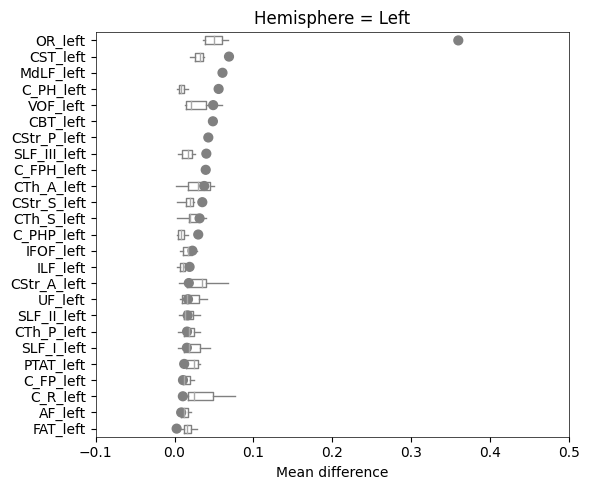

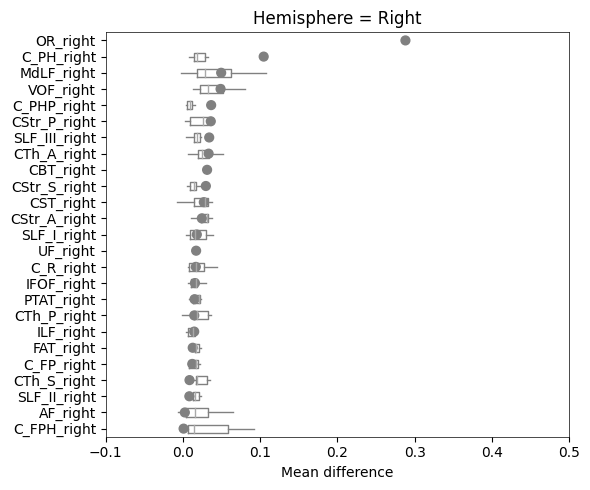

In [305]:
##### make boxplots of empirical and null adjusted R2
for hemisphere in ['Left', 'Right']:
    
    # select hemisphere regression results
    hem_df = result_df.loc[result_df['hemisphere'] == hemisphere]
   
    # initialize figure
    fig, ax1 = plt.subplots(1, 1, figsize = (6, 5))
    
    # select empirical adjusted R2 results
    diffData = hem_df.groupby('tract')['mean_difference'].first().values
    sorted_idx = np.argsort(diffData)
    diffData = np.array(diffData)[sorted_idx] # sort by largest mean difference
    
    # select tract names
    tract_names = hem_df.groupby('tract')['spin_p_val'].first().index.tolist()
    n_features = len(tract_names)
    tract_names = np.array(tract_names)[sorted_idx]

    # select model significance p-values based on spins
    pvalspin = hem_df.groupby('tract')['spin_p_val'].first().values
    pvalspin = np.array(pvalspin)[sorted_idx]
#     _, p_fdr, _, _ = multipletests(pvals = pvalspin, method = 'fdr_bh') # optional FDR correction
    
    # select spin Null mean difference values 
    null_mean_diff = hem_df.groupby('tract')['Null_mean_diff'].first().values
    null_mean_diff = np.array(null_mean_diff)[sorted_idx]

    # plot empirical mean difference against null mean differences
    colors = np.where(pvalspin < 0.05, 'lightcoral', 'grey')
    ax1.scatter(diffData, range(len(diffData)), c = colors, s = 40) # for uncorrected spin p-values
#     ax1.scatter(rsqData, range(len(rsqData)), c = (np.array(p_fdr) < 0.05).astype(int), s = 40) # replace by p_fdr if want corrected pvals
    boxplot = ax1.boxplot(null_mean_diff.T, positions = range(len(diffData)), vert = False, showcaps = False, showfliers = False, 
                boxprops = dict(color = 'grey'), whiskerprops = dict(color='grey'))

    # Set the color of the mean line to dark grey
    for line in boxplot['medians']:
        line.set_color('darkgrey')
    ax1.set_yticks(range(len(diffData)))
    ax1.set_yticklabels(tract_names, rotation = 0)
    ax1.set_xlabel('Mean difference')
    ax1.set_xlim([-0.1, 0.5])
    plt.grid(False)
    plt.title(f'Hemisphere = {hemisphere}')
    plt.tight_layout()
    plt.savefig(f'./outputs/ttests_similarity/{analysis}_{hemisphere}_meandiff_withnull.svg',
            bbox_inches = 'tight', dpi = 300,
            transparent = True)

#### Plot t-statistic results by hemisphere and tract

Here, we plot the t-statistic corresponding to the independent two-sample t-test comparing the similarity values of regions connected vs non-connected to a tract.

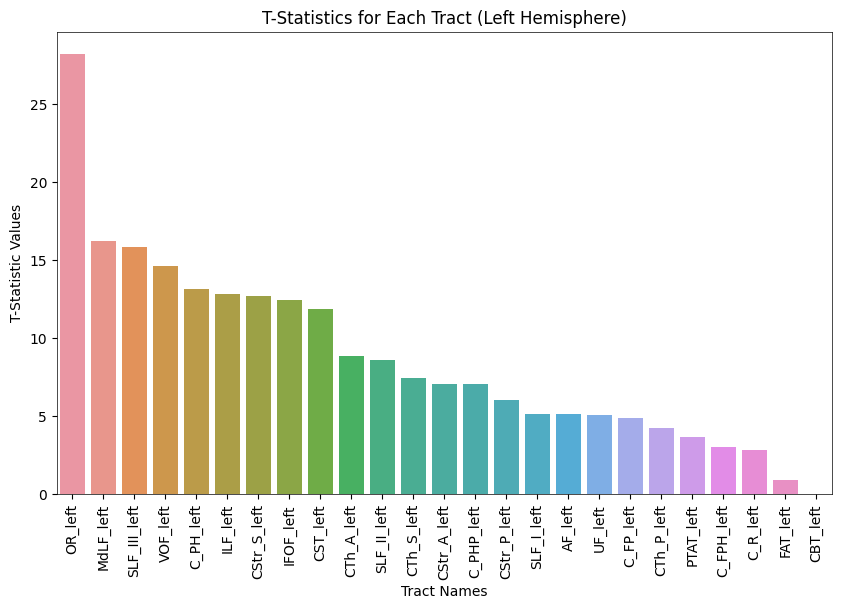

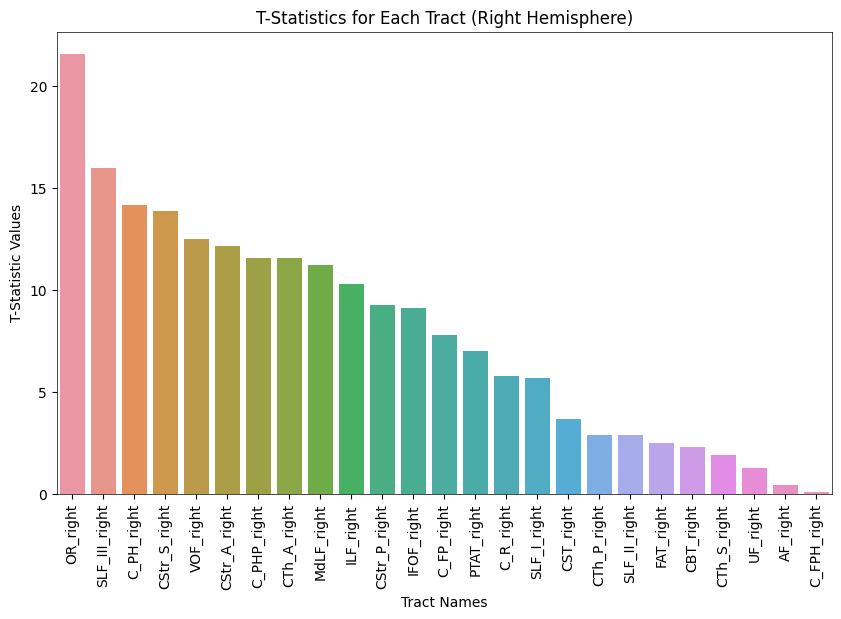

In [135]:
# Let's create separate DataFrames for each hemisphere
df_left = result_df[result_df['hemisphere'] == 'Left']
df_right = result_df[result_df['hemisphere'] == 'Right']

# For the left hemisphere
plt.figure(figsize=(10, 6))
sns.barplot(x='tract', y='t_statistic', data=df_left.sort_values('t_statistic', ascending=False))
plt.title('T-Statistics for Each Tract (Left Hemisphere)')
plt.xlabel('Tract Names')
plt.ylabel('T-Statistic Values')
plt.xticks(rotation=90)  # Rotate those tract names
plt.show()

# Now, for the right hemisphere
plt.figure(figsize=(10, 6))
sns.barplot(x='tract', y='t_statistic', data=df_right.sort_values('t_statistic', ascending=False))
plt.title('T-Statistics for Each Tract (Right Hemisphere)')
plt.xlabel('Tract Names')
plt.ylabel('T-Statistic Values')
plt.xticks(rotation=90)  # Another round of rotation
plt.show()